In [13]:
import pytesseract
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt

In [14]:
class PyImageSearchANPR:
    def __init__(self, min_ar=4, max_ar=5, debug=False):
        # store the minimum and maximum rectangular aspect ratio
        # values along with whether we are in debug mode
        self.minAR = min_ar
        self.maxAR = max_ar
        self.debug = debug

    def debug_imshow(self, title, image):
        # check to see if we are in debug mode, and if so, show the
        # image with the supplied title
        if self.debug:
            plt.figure()
            plt.title(title)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    def locate_license_plate_candidates(self, gray, keep=5):
        # perform a blackhat morphological operation that will allow
        # us to reveal dark regions (i.e., text) on light backgrounds
        # (i.e., the license plate itself)
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rect_kernel)
        self.debug_imshow("Blackhat", blackhat)

        # next, find regions in the image that are light
        square_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, square_kern)
        light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        self.debug_imshow("Light Regions", light)

        # compute the Scharr gradient representation of the blackhat
        # image in the x-direction and then scale the result back to
        # the range [0, 255]
        grad_x = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
        grad_x = np.absolute(grad_x)
        (minVal, maxVal) = (np.min(grad_x), np.max(grad_x))
        grad_x = 255 * ((grad_x - minVal) / (maxVal - minVal))
        grad_x = grad_x.astype("uint8")
        self.debug_imshow("Scharr", grad_x)

        # blur the gradient representation, applying a closing
        # operation, and threshold the image using Tsutomu's method
        grad_x = cv2.GaussianBlur(grad_x, (5, 5), 0)
        grad_x = cv2.morphologyEx(grad_x, cv2.MORPH_CLOSE, rect_kernel)
        thresh = cv2.threshold(grad_x, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        self.debug_imshow("Grad Thresh", thresh)

        # perform a series of erosion's and dilation's to clean up the
        # threshold image
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        self.debug_imshow("Grad Erode/Dilate", thresh)

        # take the bitwise AND between the threshold result and the
        # light regions of the image
        thresh = cv2.bitwise_and(thresh, thresh, mask=light)
        thresh = cv2.dilate(thresh, None, iterations=2)
        thresh = cv2.erode(thresh, None, iterations=1)
        self.debug_imshow("Final", thresh)

        # find contours in the threshold image and sort them by
        # their size in descending order, keeping only the largest
        # ones
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]
        # return the list of contours
        return cnts

    def locate_license_plate(self, gray, candidates, clear_border=False):
        # initialize the license plate contour and ROI
        lp_cnt = None
        roi = None

        # loop over the license plate candidate contours
        for c in candidates:
            # compute the bounding box of the contour and then use
            # the bounding box to derive the aspect ratio
            (x, y, w, h) = cv2.boundingRect(c)
            ar = w / float(h)

            # check to see if the aspect ratio is rectangular
            if self.minAR <= ar <= self.maxAR:
                # store the license plate contour and extract the
                # license plate from the grayscale image and then
                # threshold it
                lp_cnt = c
                license_plate = gray[y:y + h, x:x + w]
                roi = cv2.threshold(license_plate, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

                # check to see if we should clear any foreground
                # pixels touching the border of the image
                # (which typically, not but always, indicates noise)
                if clear_border:
                    roi = clear_border(roi)
                # display any debugging information and then break
                # from the loop early since we have found the license
                # plate region
                self.debug_imshow("License Plate", license_plate)
                self.debug_imshow("ROI", roi)
                break

        # return a 2-tuple of the license plate ROI and the contour
        # associated with it
        return roi, lp_cnt

    def build_tesseract_options(self, psm=7):
        # tell Tesseract to only OCR alphanumeric characters
        alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        options = "-c tessedit_char_whitelist={}".format(alphanumeric)
        # set the PSM mode
        options += " --psm {}".format(psm)
        # return the built options string
        return options

    def find_and_ocr(self, image, psm=7, clear_border=False):
        # initialize the license plate text
        lp_text = None
        # convert the input image to grayscale, locate all candidate
        # license plate regions in the image, and then process the
        # candidates, leaving us with the *actual* license plate
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
        # return
        candidates = self.locate_license_plate_candidates(gray)
        (lp, lp_cnt) = self.locate_license_plate(255-gray, candidates, clear_border=clear_border)

        # only OCR the license plate if the license plate ROI is not empty
        if lp is not None:
            # OCR the license plate
            options = self.build_tesseract_options(psm=psm)
            lp_text = pytesseract.image_to_string(lp, config=options)
            self.debug_imshow("License Plate", lp)
        # return a 2-tuple of the OCR license plate text along with
        # the contour associated with the license plate region
        return lp_text, lp_cnt


In [15]:
def cleanup_text(text):
    # strip out non-ASCII text, so we can draw the text on the image
    # using OpenCV
    return "".join([c if ord(c) < 128 else "" for c in text]).strip()


[INFO] 51F64619



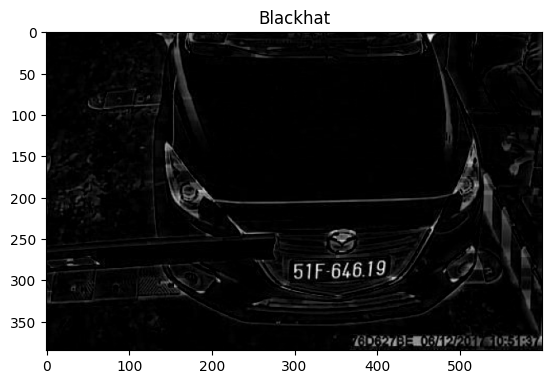

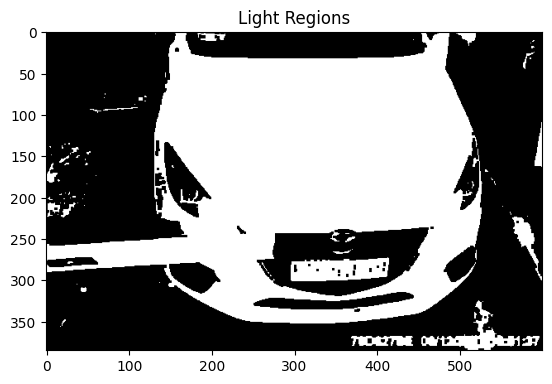

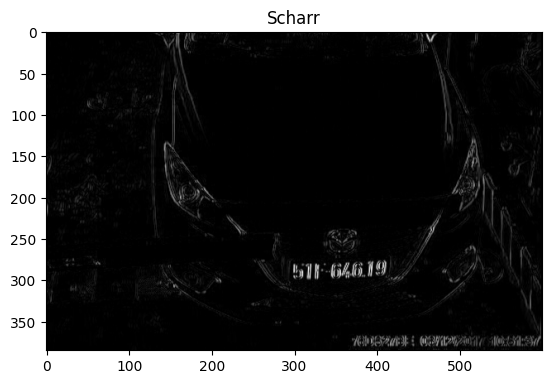

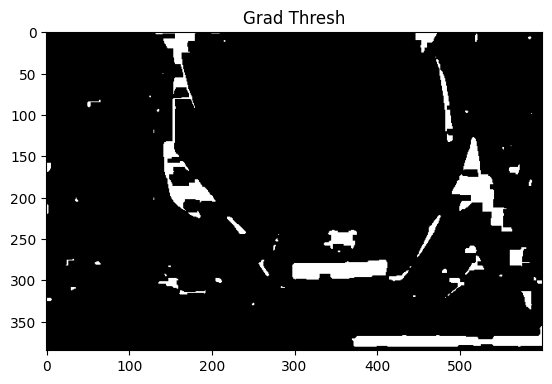

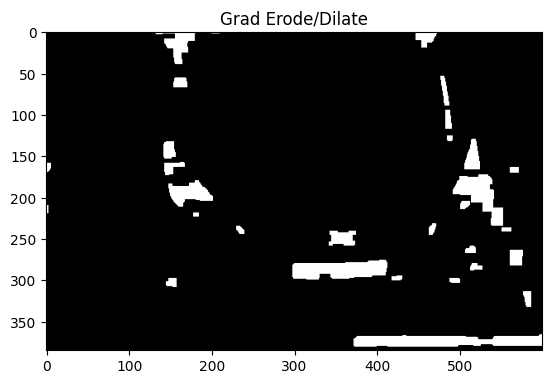

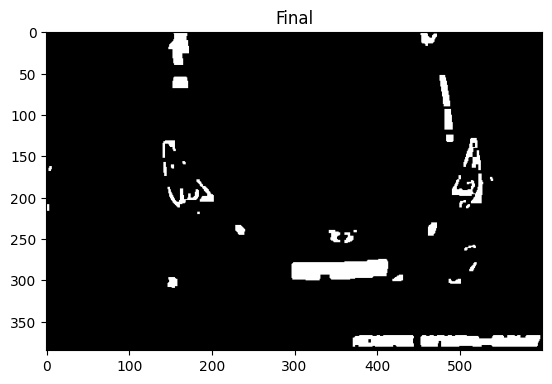

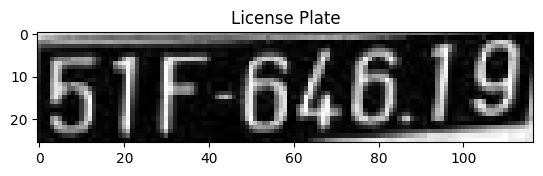

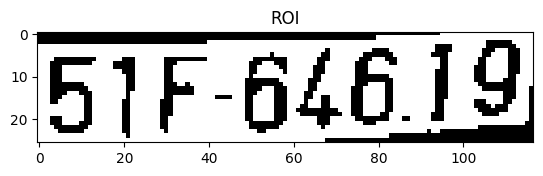

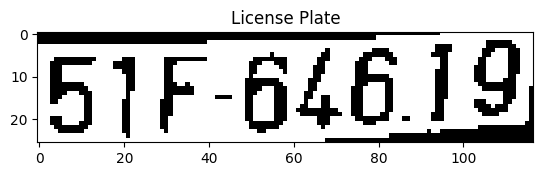

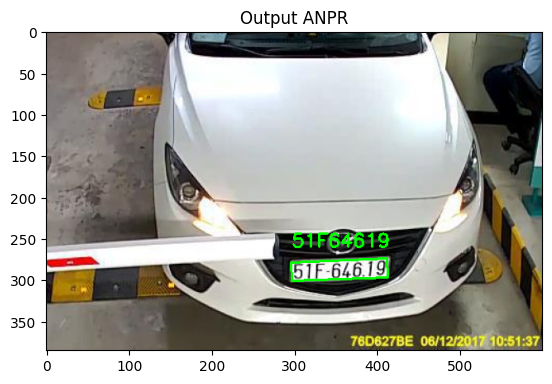

In [16]:
# initialize our ANPR class
anpr = PyImageSearchANPR(min_ar=3.5, max_ar=4.7, debug=True)

imagePath = "../../positives/car (58).jpg"
# imagePath = "datasets/1/dataset/test/CarLongPlateGen423_jpg.rf.708150d8a5af91ef75ef6e0831116e02.jpg"

image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)

# apply automatic license plate recognition
(lpText, lpCnt) = anpr.find_and_ocr(image)
# only continue if the license plate was successfully OCR'd
if lpText is not None and lpCnt is not None:
    # fit a rotated bounding box to the license plate contour and
    # draw the bounding box on the license plate
    box = cv2.boxPoints(cv2.minAreaRect(lpCnt))
    box = box.astype("int")
    cv2.drawContours(image, [box], -1, (0, 255, 0), 2)
    # compute a normal (unrotated) bounding box for the license
    # plate and then draw the OCR license plate text on the
    # image
    (x, y, w, h) = cv2.boundingRect(lpCnt)
    cv2.putText(image, cleanup_text(lpText), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
    # show the output ANPR image
    print("[INFO] {}".format(lpText))
    anpr.debug_imshow("Output ANPR", image)
